# Imports

In [1]:
from vip_hci.fits import open_fits,write_fits
import numpy as np
from matplotlib import pyplot as plt
from hciplot import plot_frames
import pandas as pd
import seaborn as sns
from scipy.signal import convolve2d
from scipy.optimize import curve_fit


In [325]:
from CCFcore.PreProcess import SINFONI
from CCFcore.CrossCorr import CrossCorr
from CCFcore import removeTelluric
import multiprocessing
from contextlib import contextmanager
from CCFcore import removeTelluric,applyFilter,measureSpatialSpec
from vip_hci.preproc.cosmetics import frame_center,cube_crop_frames,frame_crop
from vip_hci.preproc.derotation import cube_derotate
from vip_hci.metrics.stim import stim_map
from vip_hci.metrics.snr_source import snrmap, snr
from vip_hci.var.shapes import mask_circle
from vip_hci.metrics.roc import compute_binary_map
from vip_hci.psfsub import median_sub


In [3]:
plt.style.use('seaborn')

# Detection maps

In [406]:
median_ccf = open_fits("/mnt/disk12tb/Users/rakesh/SpatialDetection/MedianCCF/CCF_median_analysis/\
ccf_cont_3e-04_rad_23.0_theta_360.00.fits")

Fits HDU-0 data successfully loaded. Data shape: (61, 61, 5)


In [360]:
median_ccf[int(x_pos),int(y_pos)]

array([85.49744, 85.54808, 85.54652, 85.48254, 85.36936], dtype=float32)

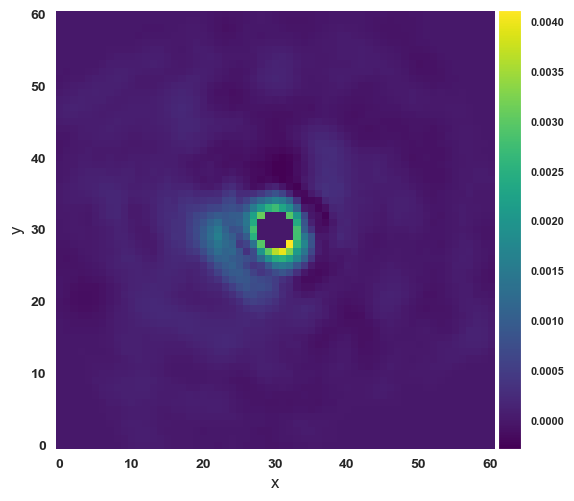

In [347]:
plot_frames(mask_circle(median_ccf[:,:,2]/np.sqrt(acf[25]),radius=2.5))

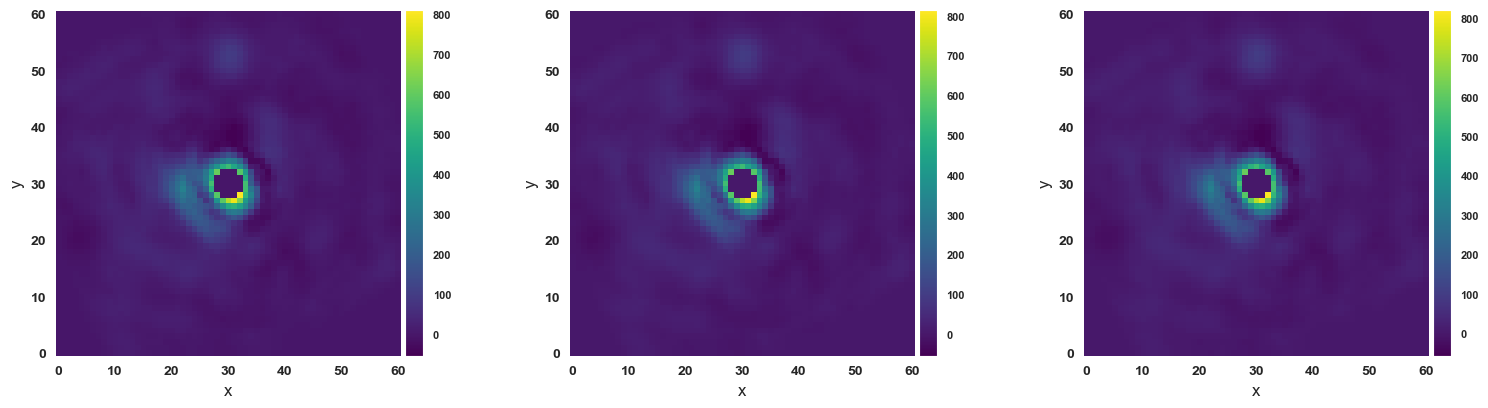

In [243]:
plot_frames((mask_circle(median_ccf[:,:,0],radius=2.4), 
             mask_circle(median_ccf[:,:,1],radius=2.4),
             mask_circle(median_ccf[:,:,2],radius=2.4)))

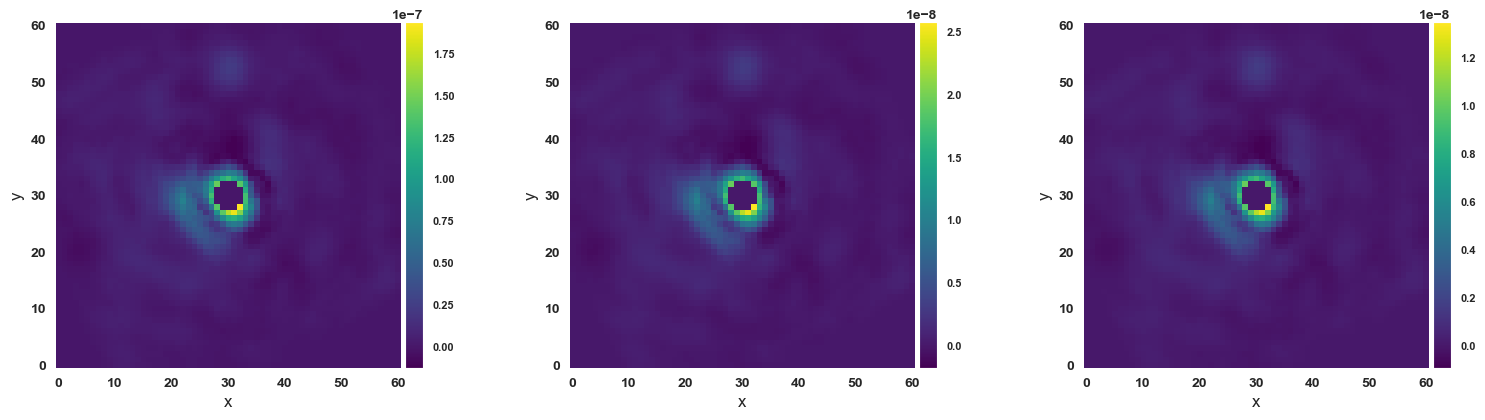

In [244]:
plot_frames((mask_circle(normalized_ccf[:,:,0],radius=2.4), 
             mask_circle(normalized_ccf[:,:,1],radius=2.4),
             mask_circle(normalized_ccf[:,:,2],radius=2.4)))

In [416]:
#median_snrmap = mask_circle(median_ccf[:,:,2]/(25*np.sqrt(acf[25])),radius=2.5)
median_snrmap = snrmap(median_ccf[:,:,2],fwhm=2,verbose = True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-06-15 20:15:22
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 28 processes
Running time:  0:00:01.412618
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


S/N for the given pixel = 5.076
Integrated flux in FWHM test aperture = 290.205
Mean of background apertures integrated fluxes = 24.288
Std-dev of background apertures integrated fluxes = 52.022


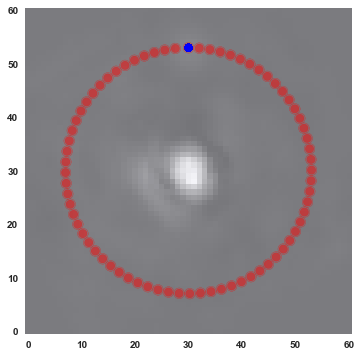

In [408]:
sourcey, sourcex, f_source, fluxes, snr_vale = snr(median_ccf[:,:,2],source_xy=(y_pos,x_pos),fwhm=2,verbose=True,
                                                   full_output=True,
                                                  plot=True)

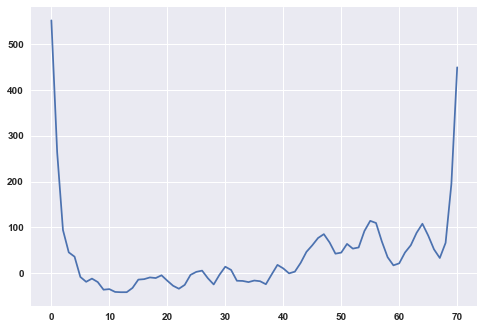

In [343]:
plt.plot(fluxes)

In [318]:
help(snrmap)

Help on function snrmap in module vip_hci.metrics.snr_source:

snrmap(array, fwhm, approximated=False, plot=False, known_sources=None, nproc=None, array2=None, use2alone=False, exclude_negative_lobes=False, verbose=True, **kwargs)
    Parallel implementation of the S/N map generation function. Applies the
    S/N function (small samples penalty) at each pixel.
    
    The S/N is computed as in [MAW14]_ for each radial separation.
    
    **DISCLAIMER**:
    Signal-to-noise ratio is not significance! For a conversion from SNR to
    n-sigma (i.e. the equivalent confidence level of a Gaussian n-sigma), use
    the ``significance`` function.
    
    
    Parameters
    ----------
    array : numpy ndarray
        Input frame (2d array).
    fwhm : float
        Size in pixels of the FWHM.
    approximated : bool, optional
        If True, an approximated S/N map is generated.
    plot : bool, optional
        If True plots the S/N map. False by default.
    known_sources : None, tuple 

In [320]:
median_snrmap.max()

13.481427

In [390]:
filename = "fitsfiles_vel/cnn_detmap_3e-04_23.0_360.00.fits"
detmap_cnn = open_fits(filename)
filename_sodinn = "fitsfiles_vel/sodinn_detmap_3e-04_23.0_360.00.fits"
detmap_sodinn = open_fits(filename_sodinn)
filename_stim = "fitsfiles/stim_detmap_3e-04_23.0_360.00.fits"
detmap_stim = open_fits(filename_stim)
filename_rf = "fitsfiles_vel/rf_detmap_3e-04_23.0_360.00.fits"
detmap_rf = open_fits(filename_rf)
#detmap_cnn = 

Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)


In [391]:
rad = float(filename.split('/')[-1].split('_')[3])
theta = float(filename.split('/')[-1].split('_')[4].split('.')[0])
cont = float(filename.split('/')[-1].split('_')[2])
y_pos = frame_center(detmap_cnn)[0]+rad*np.sin(np.deg2rad(theta))
x_pos = frame_center(detmap_cnn)[0] +rad*np.cos(np.deg2rad(theta))

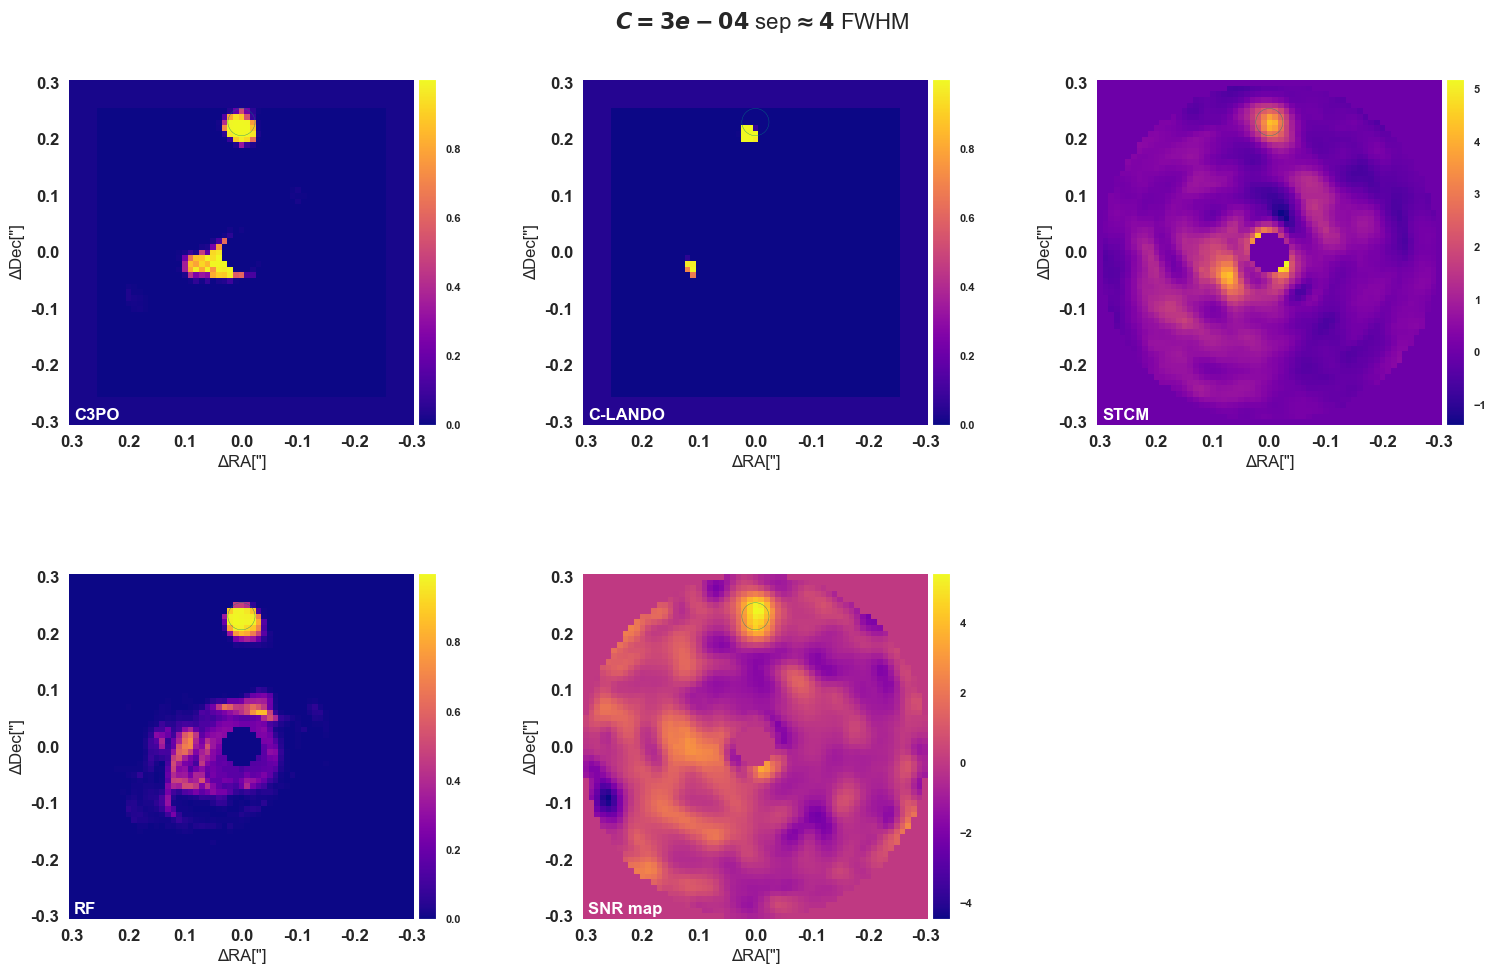

In [413]:
detmap_cnn=mask_circle(detmap_cnn,radius=1.9)
detmap_sodinn = mask_circle(detmap_sodinn,radius=1.9)
detmap_stim = mask_circle(detmap_stim,radius=1.9)
plot_frames((detmap_cnn,detmap_sodinn,detmap_stim,detmap_rf,mask_circle(median_snrmap,radius=3.4)),
            cmap='plasma',
           ang_scale=True,
           ang_ticksep=10,
            circle=(y_pos,x_pos),
            circle_color='teal',
            circle_radius=2.4,
           label=('C3PO','C-LANDO','STCM','RF','SNR map'),
           title ="$C=%1.0e$ sep$\\approx %1.0d$ FWHM"%(cont,int(rad/4.8)),
           rows=2)#,
           #save="/mnt/diskss/home/rnath/Monday_meetings/PaperPlots_06.11.2022/detmaps_vels_18.0_5e-04.png",
           # dpi=400,
           #rows=2)

In [417]:
try:
    thresh_cnn = np.linspace(0.09,0.9999,10)
    res_cnn =compute_binary_map(detmap_cnn,
                            thresholds = thresh_cnn,fwhm=4.8,injections=(y_pos,x_pos),npix=2,
                            overlap_threshold=0.5,
                            max_blob_fact=3)
except AttributeError:
    #thresh_cnn = np.linspace(0.09,0.95,10)
    res_cnn =compute_binary_map(detmap_cnn,
                            thresholds=thresh_cnn[0:-1],fwhm=4.8,injections=(y_pos,x_pos),npix=2,
                            overlap_threshold=0.5,
                            max_blob_fact=1)
try:
    res_sodinn = compute_binary_map(detmap_sodinn, 
                                    thresholds=thresh_cnn,fwhm=4.8,injections=(y_pos,x_pos),
                                    npix=2)
except AttributeError:
    res_sodinn = compute_binary_map(detmap_sodinn, 
                                    thresholds=thresh_cnn[0:-1],fwhm=4.8,injections=(y_pos,x_pos),
                                    npix=2)
try:
    thresh_rf=np.linspace(0.01,0.99,10)
    res_rf = compute_binary_map(detmap_rf, 
                                    thresholds=thresh_rf,fwhm=4.8,injections=(y_pos,x_pos),
                                    npix=2)
except AttributeError:
    thresh_rf=np.linspace(0.01,0.7,10)
    res_rf = compute_binary_map(detmap_rf, 
                                    thresholds=thresh_rf,fwhm=4.8,injections=(y_pos,x_pos),
                                    npix=2)


thresh_stim =np.linspace(1.3,5.9,10)
try:
    res_stim = compute_binary_map(detmap_stim,thresholds=thresh_stim,
                                  fwhm=4.8,injections=(y_pos,x_pos),npix=1,
                                 max_blob_fact=4)
except AttributeError:
    thresh_stim = thresh_stim[0:-1]
    try:
        res_stim = compute_binary_map(detmap_stim,thresholds=thresh_stim,
                                      fwhm=4.8,injections=(y_pos,x_pos),npix=1,
                                     max_blob_fact=4)
    except AttributeError:
        thresh_stim = thresh_stim[0:-1]
        res_stim = compute_binary_map(detmap_stim,thresholds=thresh_stim,
                                      fwhm=4.8,injections=(y_pos,x_pos),npix=1,
                                     max_blob_fact=4)
thresh_snr = np.linspace(1,6,10)
median_snrmap = mask_circle(median_snrmap,radius=2.4)
for lim in range(len(thresh_snr),2,-1):

    try:
        res_snr = compute_binary_map(median_snrmap,thresholds=thresh_snr,
                                      fwhm=4.8,injections=(y_pos,x_pos),npix=1,
                                     max_blob_fact=4)
    except AttributeError:
        #for i in range
        thresh_snr = thresh_snr[0:lim]
        try:
            res_snr = compute_binary_map(median_snrmap,thresholds=thresh_snr,
                                          fwhm=4.8,injections=(y_pos,x_pos),npix=1,
                                         max_blob_fact=4)
            break
        except AttributeError:
            continue


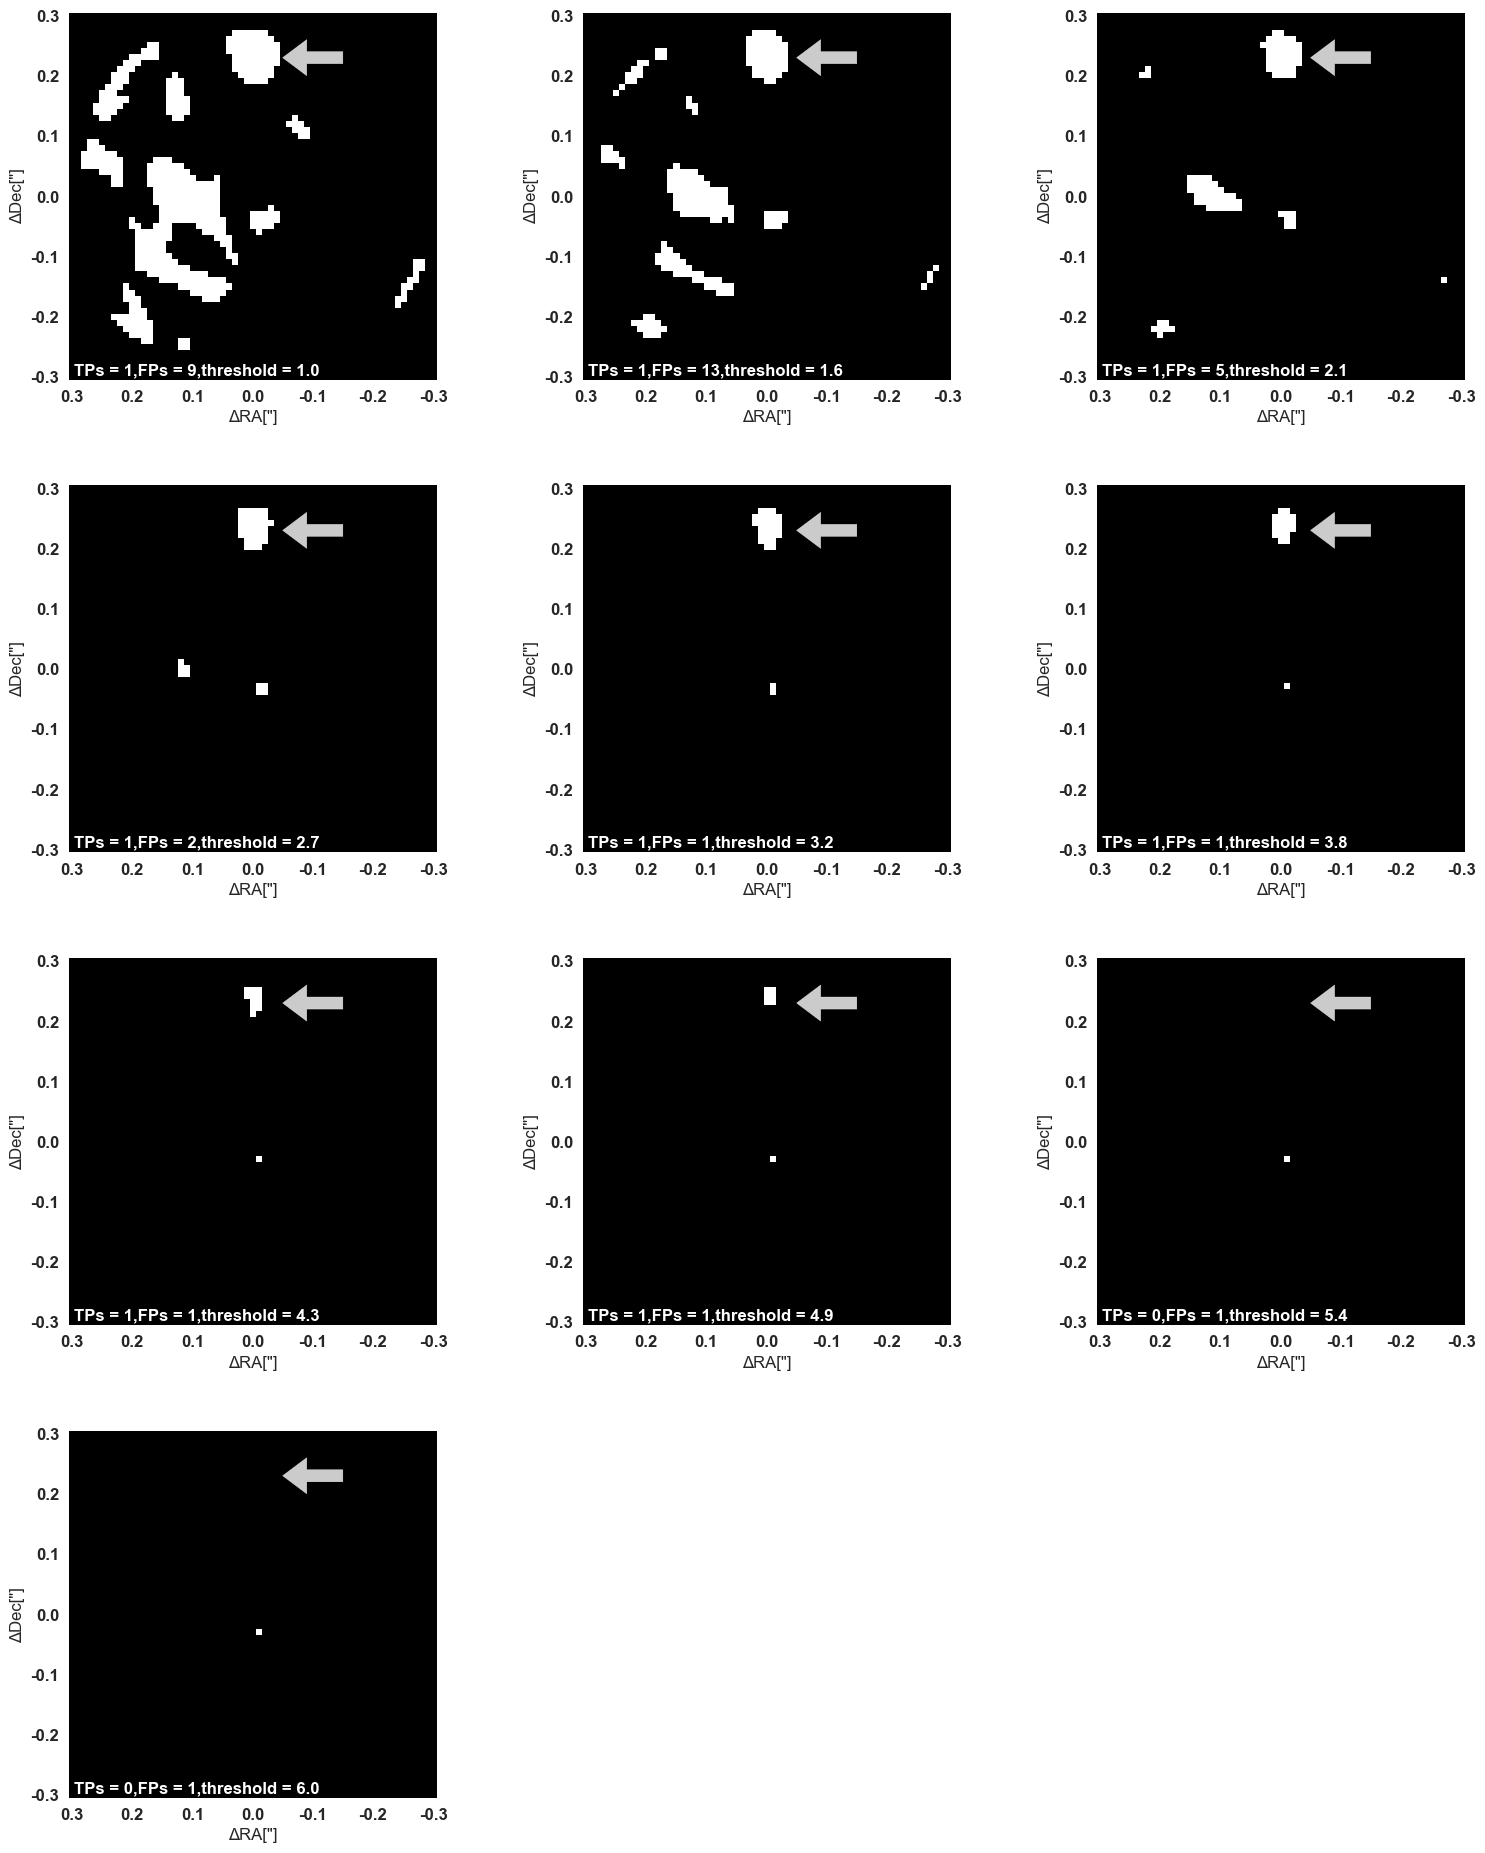

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0] [9, 13, 5, 2, 1, 1, 1, 1, 1, 1] [1.         1.55555556 2.11111111 2.66666667 3.22222222 3.77777778
 4.33333333 4.88888889 5.44444444 6.        ]


In [418]:
obj = res_snr
labs = tuple(["TPs = {0},FPs = {1},threshold = {2:3.1f}".format(o1,o2,o3) for o1,o2,o3 in zip(obj[0],obj[1],thresh_snr)])
plot_frames(tuple(obj[2]),rows=4,
            ang_scale=True,ang_ticksep=10,arrow=(y_pos,x_pos),circle_radius=0.1,
            circle_color ='red',
            circle_alpha = 1.0,
            cmap='gray',
           label=labs,
           colorbar=False)
print(obj[0],obj[1],thresh_snr)

In [289]:
labs

('TPs = 1,FPs = 1,threshold = 1.0',
 'TPs = 0,FPs = 1,threshold = 1.6',
 'TPs = 0,FPs = 1,threshold = 2.1')

In [142]:
help(plot_frames)

Help on function plot_frames in module hciplot.hciplot:

plot_frames(data, backend='matplotlib', mode='mosaic', rows=1, vmax=None, vmin=None, circle=None, circle_alpha=0.8, circle_color='white', circle_linestyle='-', circle_radius=6, circle_label=False, circle_label_color='white', arrow=None, arrow_alpha=0.8, arrow_length=10, arrow_shiftx=5, arrow_label=None, label=None, label_pad=5, label_size=12, label_color='white', grid=False, grid_alpha=0.4, grid_color='#f7f7f7', grid_spacing=None, cross=None, cross_alpha=0.4, lab_fontsize=8, cross_color='white', ang_scale=False, ang_ticksep=50, ndec=1, pxscale=0.01, auscale=1.0, ang_legend=False, au_legend=False, axis=True, show_center=False, cmap=None, log=False, colorbar=True, colorbar_ticks=None, dpi=100, size_factor=6, horsp=0.4, versp=0.2, width=400, height=400, title=None, tit_size=16, sampling=1, save=None, transparent=False)
    Plot a 2d array or a tuple of 2d arrays. Supports the ``matplotlib`` and
    ``bokeh`` backends. When having a 

In [112]:
len(obj[0])

10

In [113]:
len(thresh_cnn)

10

In [233]:
plot_frames((obj[-1][0],obj[-1][4],obj[-1][-1]),
           rows=3,ang_scale=True,ang_ticksep=10,circle=(y_pos,x_pos),
            circle_radius=2.5,
            circle_color='r',
            cmap='gray',
           label=(labs[0],labs[4],labs[-1]),
           colorbar=False,
           save="/mnt/diskss/home/rnath/Monday_meetings/PaperPlots_06.11.2022/sample_stim_binmaps.png")

`Pixel scale set to 0.01`


# ROC

In [419]:
mask = 3.5
start_pix =19.0
end_pix =23.0
C_low = 1e-04
C_high = 3e-04
tpr_stim_vel = open_fits("stats_roc_runs_vel/tpr_stim_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
tpr_sodinn_vel = open_fits("stats_roc_runs_vel/tpr_sodinn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
tpr_cnn_vel = open_fits("stats_roc_runs_vel/tpr_cnn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
fpr_stim = open_fits("stats_roc_runs_vel/fpr_stim_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
fpr_sodinn_vel = open_fits("stats_roc_runs_vel/fpr_sodinn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
#fpr_rf_2 = open_fits("stats_roc_runs/fpr_rf_mask_3.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
fpr_cnn_vel = open_fits("stats_roc_runs_vel/fpr_cnn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
thresh_stim_vel = open_fits("stats_roc_runs_vel/thresh_stim_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
thresh_cnn_vel = open_fits("stats_roc_runs_vel/thresh_cnn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
thresh_sodinn_vel = open_fits("stats_roc_runs_vel/thresh_sodinn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))

Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)


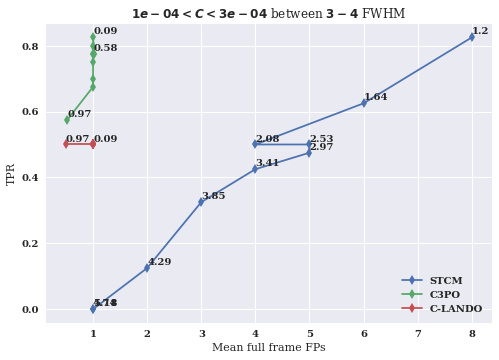

In [301]:
f,ax = plt.subplots(1,1)
for i in range(10):
    ax.text(fpr_stim[i],tpr_stim_vel[i]+0.01,str(np.round(thresh_stim_vel[i],2)))
ax.plot(fpr_stim,tpr_stim_vel,label='STCM',marker='d')
ax.plot(fpr_cnn_vel,tpr_cnn_vel,label='C3PO',marker ='d')
for i in [0,5,9]:
    ax.text(fpr_cnn_vel[i],tpr_cnn_vel[i]+0.01,str(np.round(thresh_cnn_vel[i],2)))
ax.plot(fpr_sodinn_vel,tpr_sodinn_vel,label='C-LANDO',marker='d')
for i in [0,9]:
    ax.text(fpr_sodinn_vel[i],tpr_sodinn_vel[i]+0.01,str(np.round(thresh_sodinn_vel[i],2)))
ax.legend()
ax.set_xlabel("Mean full frame FPs")
ax.set_ylabel("TPR")
#ax.set_xscale('log')
plt.legend()
plt.xlabel("Mean full frame FPs")
plt.ylabel("TPR")
plt.title("$%1.0e<C<%1.0e$ between $%d-%d$ FWHM"%(C_low,C_high,int(start_pix/5.1),int(end_pix/5)))
#plt.savefig("/mnt/diskss/home/rnath/Monday_meetings/FRIAplot/wit
plt.savefig("/mnt/diskss/home/rnath/Monday_meetings/PaperPlots_06.11.2022/\
roc_{0:1.0e}_{1:1.0e}_from_{2:1.0f}_{3:1.0f}.png".format(C_low,C_high,start_pix,end_pix)
            ,dpi =300)

No handles with labels found to put in legend.


Help on Legend in module matplotlib.legend object:

class Legend(matplotlib.artist.Artist)
 |  Legend(parent, handles, labels, loc=None, numpoints=None, markerscale=None, markerfirst=True, scatterpoints=None, scatteryoffsets=None, prop=None, fontsize=None, labelcolor=None, borderpad=None, labelspacing=None, handlelength=None, handleheight=None, handletextpad=None, borderaxespad=None, columnspacing=None, ncol=1, mode=None, fancybox=None, shadow=None, title=None, title_fontsize=None, framealpha=None, edgecolor=None, facecolor=None, bbox_to_anchor=None, bbox_transform=None, frameon=None, handler_map=None)
 |  
 |  Place a legend on the axes at location loc.
 |  
 |  Method resolution order:
 |      Legend
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, parent, handles, labels, loc=None, numpoints=None, markerscale=None, markerfirst=True, scatterpoints=None, scatteryoffsets=None, prop=None, fontsize=None, labelcolor=None, bord

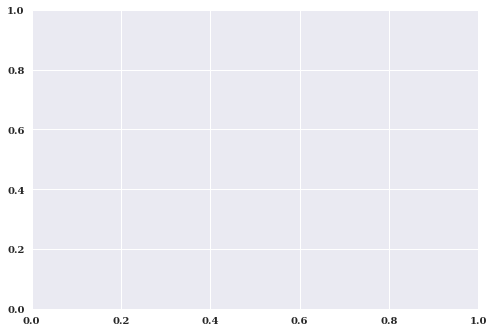

In [182]:
help(plt.legend())

In [153]:
(int(start_pix/5)+int(end_pix/5))/2

2.5

# Discussion

## comparing between algos

In [279]:
prefix = "/mnt/disk12tb/Users/rakesh/SpatialDetection/Data/H1patches_LCfov11/"
h1_patches = open_fits(prefix+"H1_seq_training_cont_3e-04_rad_21.0_theta_300.00.fits")

Fits HDU-0 data successfully loaded. Data shape: (83, 3, 11, 11)


In [280]:
plot_frames(tuple(np.median(h1_patches[0:83:25,:,:,:],axis=1)), 
            rows =3,
            ang_scale=True,
            ang_ticksep=5,
            colorbar=False,
           label=("cube 0","cube 25","cube 50","cube 75"),
            save = "/mnt/diskss/home/rnath/Monday_meetings/PaperPlots_06.11.2022/patches_time_disc.png",
            dpi = 400)

`Pixel scale set to 0.01`


In [281]:
plot_frames((np.mean(np.median(h1_patches[0:83,:,:,:],axis=1),axis=0)), 
            rows =4,
            ang_scale=True,
            ang_ticksep=5,
            colorbar=False,
            save = "/mnt/diskss/home/rnath/Monday_meetings/PaperPlots_06.11.2022//patches_mean.png",
            dpi = 400)

`Pixel scale set to 0.01`


## Velocity vs no velocity

In [282]:
#fpf_stim=[516., 414., 297., 371., 342., 217., 195.,  72.,  58.,  52.,] 
fpf_cnn=[282., 158., 150., 152., 150., 150.,  75.,  75.,  75.,  75.,] 
fpf_sodinn=[225., 225., 225., 224., 148., 142.,  75.,  75.,  76.,  75.,] 
fpf_rf =[145.,  77.,  75.,  75., 156., 150., 150., 150., 225.,  75.,]
#tpf_stim=[67., 51., 50., 50., 49., 45., 34., 26., 25., 23.,]
tpf_cnn=[55., 54., 52., 50., 50., 50., 50., 50., 50., 42.,] 
tpf_sodinn=[51., 52., 50., 49., 48., 46., 46., 46., 46., 37.,] 
tpf_rf=[50., 50., 50., 50., 50., 45., 41., 34., 25.,  0.,]


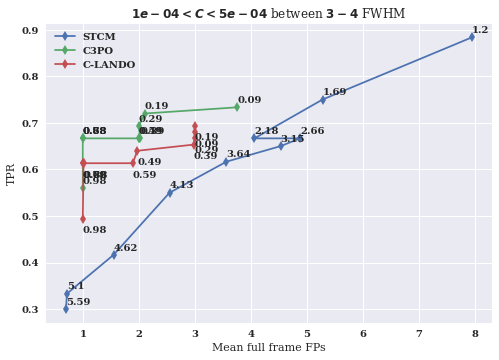

In [297]:
f,ax = plt.subplots(1,1)
ax.plot(fpr_stim,tpr_stim_vel,marker='d',label='STCM')
for i in range(10):
    ax.text(fpr_stim[i],tpr_stim_vel[i]+0.01,str(np.round(thresh_stim_vel[i],2)))
ax.plot(np.asarray(fpf_cnn)/75.0,np.asarray(tpf_cnn)/75.,marker='d',label='C3PO')
for i in range(10):
    ax.text(fpf_sodinn[i]/75,tpf_sodinn[i]/75.-0.03,str(np.round(thresh_sodinn_vel[i],2)))
ax.plot(np.asarray(fpf_sodinn)/75.0,np.asarray(tpf_sodinn)/75.,marker='d',label='C-LANDO')
for i in range(10):
    ax.text(fpf_cnn[i]/75,tpf_cnn[i]/75.+0.01,str(np.round(thresh_cnn_vel[i],2)))
    plt.xlabel("Mean full frame FPs")
    
plt.legend()
plt.ylabel("TPR")
plt.title("$%1.0e<C<%1.0e$ between $%d-%d$ FWHM"%(C_low,C_high,int(start_pix/5.1),int(end_pix/5)))
#plt.savefig("/mnt/diskss/home/rnath/Monday_meetings/FRIAplot/wit
plt.savefig("/mnt/diskss/home/rnath/Monday_meetings/PaperPlots_06.11.2022/\
novelroc_{0:1.0e}_{1:1.0e}_from_{2:1.0f}_{3:1.0f}.png".format(C_low,C_high,start_pix,end_pix)
            ,dpi =300)

## physical limit

In [259]:
stims=[]
cnns =[]
sodinns=[]
locs =[]
for ang in [60,120,180,360]:
    
    filename = "fitsfiles_vel/cnn_detmap_1e-04_18.0_{0:3.2f}.fits".format(ang)
    detmap_cnn = open_fits(filename)
    rad = float(filename.split('/')[-1].split('_')[3])
    theta = float(filename.split('/')[-1].split('_')[4].split('.')[0])
    cont = float(filename.split('/')[-1].split('_')[2])
    y_pos = 30+rad*np.sin(np.deg2rad(theta))
    x_pos = 30 +rad*np.cos(np.deg2rad(theta))
    locs.append(tuple([y_pos,x_pos]))
    cnns.append(detmap_cnn)
    filename_sodinn = "fitsfiles_vel/sodinn_detmap_1e-04_18.0_{0:3.2f}.fits".format(ang)
    detmap_sodinn = open_fits(filename_sodinn)
    sodinns.append(detmap_sodinn)
    filename_stim = "fitsfiles/stim_detmap_1e-04_18.0_{0:3.2f}.fits".format(ang)
    detmap_stim = open_fits(filename_stim)
    stims.append(detmap_stim)

Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)


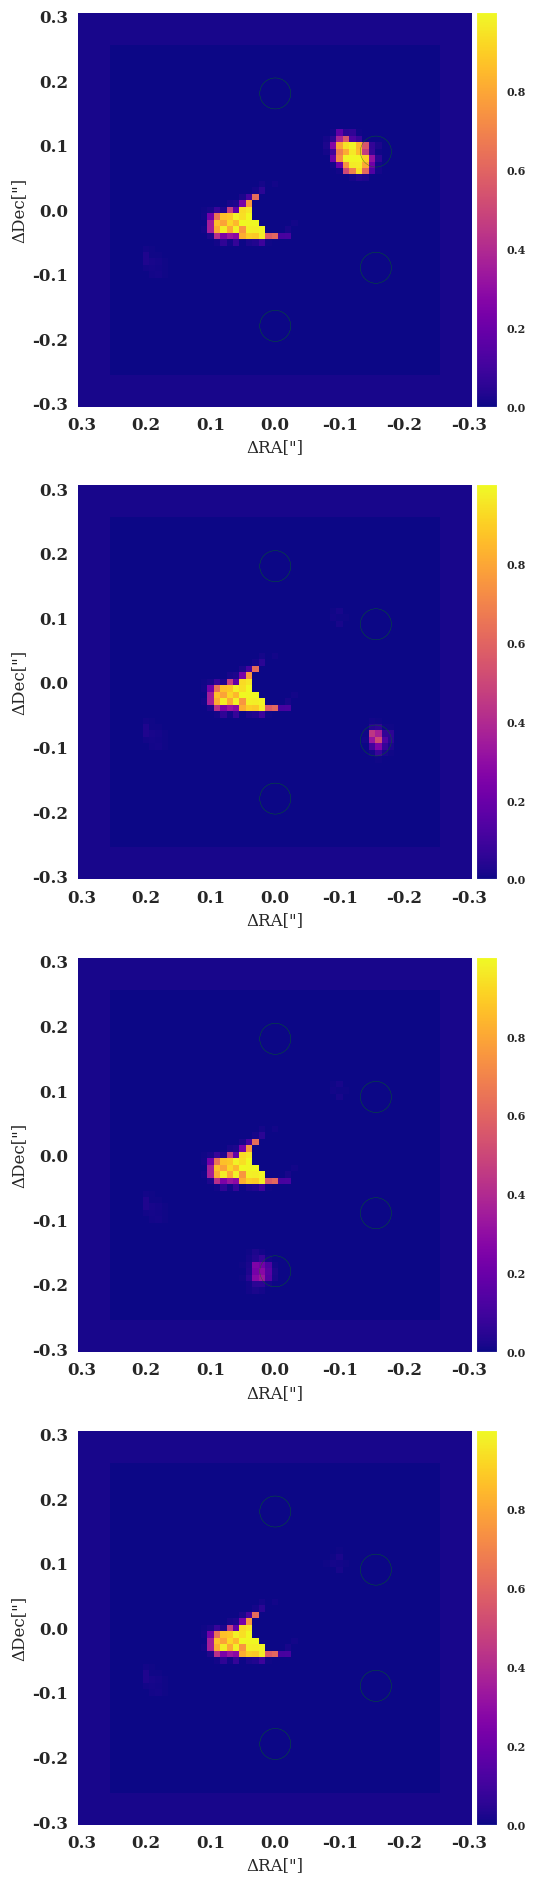

In [263]:

plot_frames(tuple(cnns),
           cmap='plasma',
           ang_scale=True,
           ang_ticksep=10,
            circle=tuple(locs),
            circle_color='green',
            circle_radius=2.4,
           rows=4)

## Appendix

In [393]:
res_snr

([1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [8, 16, 9, 3, 1, 1, 1, 1, 1, 1],
 [array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, 

In [399]:
from matplotlib import colors
pmaps=[]
tps=[]
fps=[]
ths=[]
obj = res_snr
for i in range(10):
    val = obj[2][i]
    tps.append(obj[0][i])
    fps.append(obj[1][i])
    ths.append(thresh_snr[i])
    #posns=(np.unravel_index(np.where(obj[2][1]),obj[2][1].shape))
    #print(obj[1])
    #all_pos=[]

    masked = mask_circle(val,cy=x_pos,cx=y_pos,radius=7,fillwith=False)
    #plt.pcolormesh(masked,cmap='Reds')
    #plt.pcolormesh(val,cmap='viridis')
    #val[masked] = -1
    pmap=np.ones(val.shape)*-1
    #pmap =
    pmap[val] = 1
    pmap[masked] = 0
    #pmap[pmap==0]=np.nan
    custom_cmap = colors.ListedColormap(['black','red','green'])
    pmaps.append(pmap)

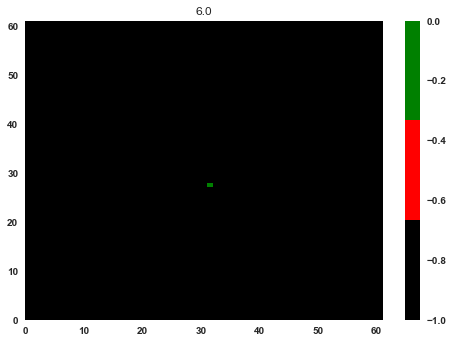

In [400]:
plt.pcolormesh(pmaps[-1],cmap =custom_cmap)
plt.title(thresh_snr[-1])
plt.colorbar()

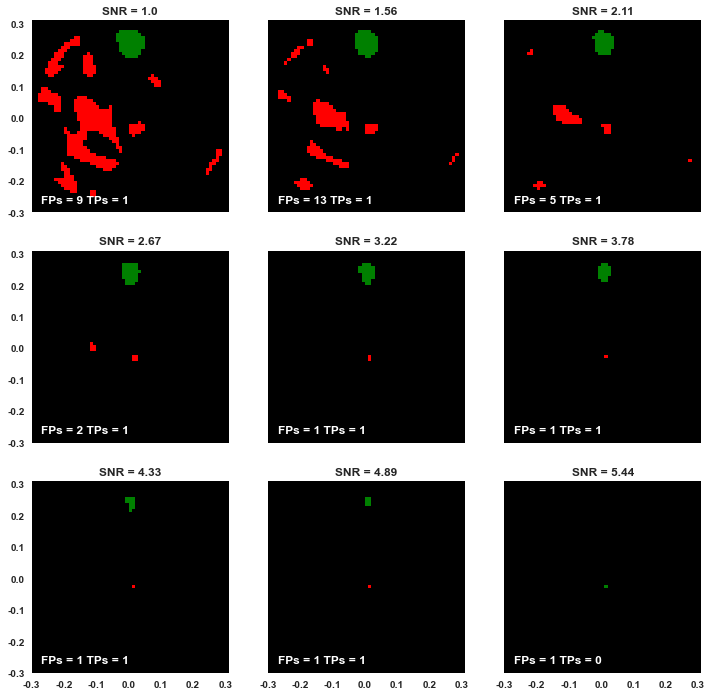

In [401]:
f, axs = plt.subplots(3,3,sharex=True,sharey =True, figsize =(12,12))
for i in range(3):
    for j in range(3):
        index = i*3+j
        axs[i][j].pcolormesh(pmaps[index],cmap = custom_cmap)
        axs[i][j].text(3,3,"FPs = {0:1d} TPs = {1:1d}".format(fps[index],tps[index]),color='w',size=12)
        axs[i][j].set_xticks(np.arange(0,70,10))
        axs[i][j].set_xticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=10)
        axs[i][j].set_yticks(np.arange(0,70,10))
        axs[i][j].set_yticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=10)
        axs[i][j].set_title("SNR = {}".format(np.round(thresh_snr[index],2)),fontweight = 'bold')
#f.savefig("/mnt/diskss/home/rnath/SpatialDetectionML/PaperPlots_Dec2022/appendix_1.png",dpi = 300)